<a href="https://colab.research.google.com/github/khemsu/Data_Warehosuing_and_mining_labs/blob/main/Building_Multi_AI_Agents_Chatbots_With_External_Tools_With_LangGraphi_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph langsmith langchain langchain-groq langchain_community

In [2]:
from typing import Annotated
from typing_extensions import TypedDict


In [3]:
!pip install arxiv wikipedia

##working with tools


In [4]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

##Arxiv and wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)


In [5]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

## adding wiki tools

In [7]:
tools=[wiki_tool]

In [8]:
##langGraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [9]:
from langgraph.graph import StateGraph,START,START,END

In [10]:
graph_builder=StateGraph(State)

In [11]:
from google.colab import userdata
groq_api_key=userdata.get("Groq_api_key")

## Creating llm


In [12]:
from langchain_groq import ChatGroq

In [13]:
llm = ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

Binding tools to llm

In [14]:
llm.bind_tools(tools=tools)

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d3b16a440d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d3b163fa9d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

## Now storing in llm_with_tool

In [15]:
llm_with_tools = llm.bind_tools(tools=tools)


## Node


In [16]:
def chatbot(state: State):
    print("User input:", state["messages"][-1])
    response = llm_with_tools.invoke(state["messages"])
    print("LLM response:", response)
    return {
        "messages": state["messages"]
    }


In [17]:
from langgraph.prebuilt import ToolNode,tools_condition

## Adding nodes and edges


In [18]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [19]:
graph=graph_builder.compile()

In [20]:
!pip install ipython



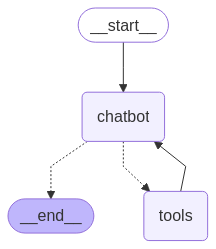

In [21]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [23]:
user_input="Hi there!, My name is khemsu"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is khemsu
User input: content='Hi there!, My name is khemsu' additional_kwargs={} response_metadata={} id='e361785b-88dc-420f-8914-134483b2d3fc'
LLM response: content='' additional_kwargs={'tool_calls': [{'id': 'call_2fdf', 'function': {'arguments': '{"query":"khemsu"}', 'name': 'wikipedia'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 988, 'total_tokens': 1070, 'completion_time': 0.149090909, 'prompt_time': 0.034716007, 'queue_time': 0.017998728999999998, 'total_time': 0.183806916}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--2e42d5e1-33b9-4df7-8303-b92698efdad9-0' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'khemsu'}, 'id': 'call_2fdf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 988, 'output_tokens': 82, 'total_tokens': 1070}
====